We would like to use a data set of wind speed at 12 weather stations in Ireland as input to predict, let's say,  the output of wind turbines.

The data set is from Haslett and Raftery, 1989, see 'wind.descr'.

In [1]:
# A few useful imports and settings for plotting.

import numpy as np
import pandas as pd

%pylab inline

font = {'size'   : 18}
pyplot.rc('font', **font)
pyplot.rc('xtick', labelsize=14) 
pyplot.rc('ytick', labelsize=14)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data set
filename = 'wind.data'
data = np.loadtxt(filename)
# Discard the first three columns, as they contain a date.
wind = data[:, 3:]

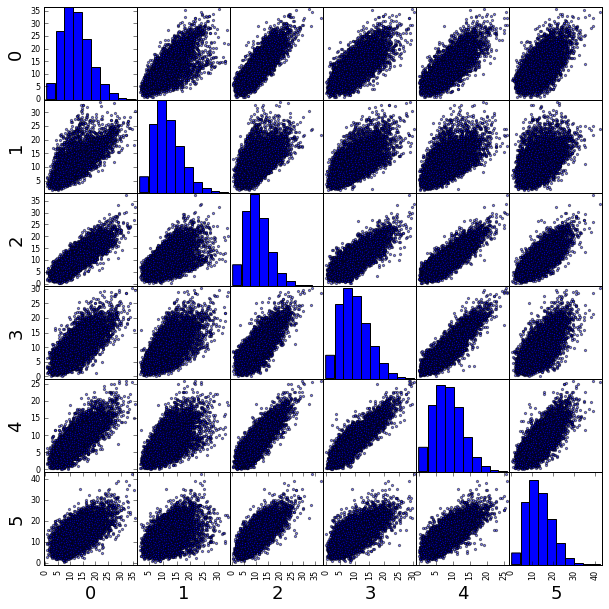

In [3]:
# Let's have a look at the data
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
_ = pd.scatter_matrix(pd.DataFrame(wind[:,::2]))

The wind speed at all weather station is strongly correlated! This can be a problem for a regression algorithm, so let's keep just as many component as necessary to preserve 95% of the total variance.

In [4]:
from sklearn.decomposition import PCA

# Keep 95% of the total variance, and normalize the transformed data.
pca = PCA(n_components=0.95, whiten=True)

# Alternatively, we could specify a fixed number of output components if we prefer.
#pca = PCA(n_components=5, whiten=True)

# `fit_transform` is equivalent to performing `fit`, then `transform`
pca_wind = pca.fit_transform(wind)

In [5]:
print 'Final dimensionality:', pca.n_components_
print 'Explained variance in %:', pca.explained_variance_ratio_.round(3) * 100

Final dimensionality: 6
Explained variance in %: [ 76.7   7.7   5.    2.7   2.6   1.2]


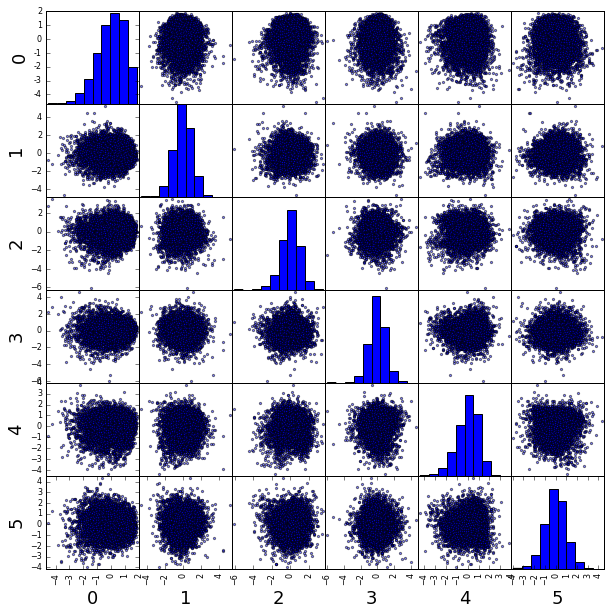

In [6]:
# Plot the transformed data.
_ = pd.scatter_matrix(pd.DataFrame(pca_wind))

(-0.2, 0.2)

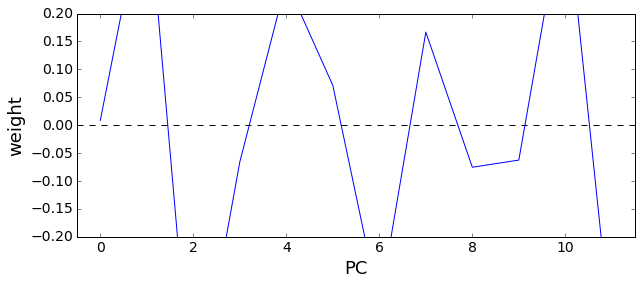

In [7]:
# What do the Principal Components corresponding to the largest variance look like?
pylab.rcParams['figure.figsize'] = (10.0, 4.0)

plot(pca.components_[2,:])
plot([-0.5, 11.5], [0, 0], 'k--')

xlabel('PC')
ylabel('weight')
xlim([-0.5, 11.5])
ylim([-0.2, 0.2])

Looking at the data as a vector is not very infomative... However, we know to which weather station each point corresponds to, and we can look up their coordinates!

The startion order is RPT, VAL, ROS, KIL, SHA, BIR, DUB, CLA, MUL, CLO, BEL, MAL in the figure:
<img src="files/ireland_wind_stations.png">

In [8]:
# Longitude and latitude for each weather station (from Google)
stations_lons = [-8.2546, -10.35, -6.3344, -7.2561, -8.8686, -7.9133, -6.2597, -8.9983, -7.3378, -7.2337, -9.991, -7.3667]
stations_lats = [51.793, 51.9, 52.2556, 52.6477, 52.7137, 53.0914, 53.3478, 53.7169, 53.5224, 54.183, 54.225, 55.3833]

In [9]:
# We create a grid of points around the geographical coordinates
# or Ireland.

llcrnrlon, urcrnrlon = -11., -5.0
llcrnrlat, urcrnrlat = 51.4, 55.5

lons = np.linspace(llcrnrlon, urcrnrlon, 50)
lats = np.linspace(llcrnrlat, urcrnrlat, 50)

lons, lats = meshgrid(lons, lats)

In [10]:
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata

def plot_vector_on_map(v):
    """ Interpolate data on coordinates grid and display on map. """
    stations_coords = zip(stations_lons, stations_lats)
    grid_coords = zip(lons.ravel(), lats.ravel())
    data = griddata(stations_coords, v, grid_coords)
    data = data.reshape(lons.shape)

    # Create Basemap axes around Ireland.
    map = Basemap(projection='merc', resolution = 'i', 
                  llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                  urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)

    # Draw the coast lines.
    map.drawcoastlines()
    # Draw the interpolated data.
    map.imshow(data, vmin=-0.1, vmax=0.1, cmap=plt.cm.RdBu_r)
    
    # Plot weather station position.
    # Transform first to map coordinates.
    x, y = map(stations_lons, stations_lats)
    map.plot(x, y, 'or')

    colorbar()

When displayed on a map, the data makes a lot more sense!

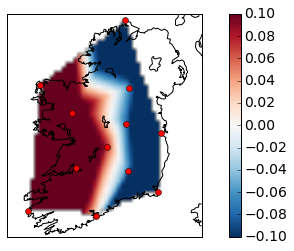

In [11]:
plot_vector_on_map(pca.components_[2,:])

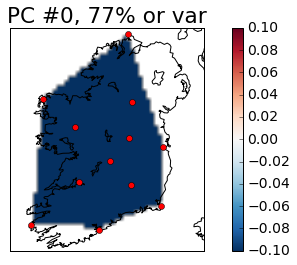

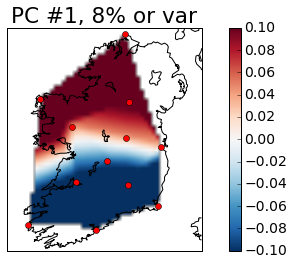

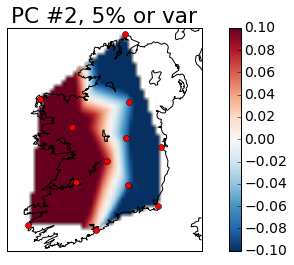

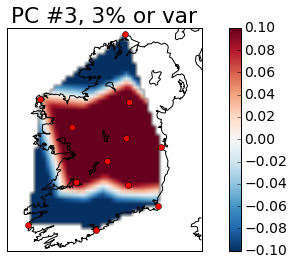

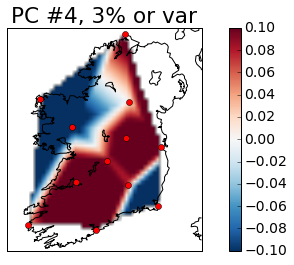

In [12]:
for idx in range(5):
    plot_vector_on_map(pca.components_[idx, :])
    explained_variance = pca.explained_variance_ratio_[idx] * 100.0
    title('PC #{}, {:.0f}% or var'.format(idx, explained_variance))
    show()

Each Principal Component corresponds to the "gradients" created by the most prominent wind patterns in Ireland.